In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# directory
base_dir = r"BrEaST-Lesions_USG-images_and_masks"

# Training and testing
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# rescaling 
train_datagen = ImageDataGenerator(rescale=1/255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255)

# Create a stream for training
train_dataset = train_datagen.flow_from_directory(
    directory=train_dir, 
    target_size=(256, 256), 
    batch_size=8, 
    class_mode='binary'
)

# Create a stream for testing
test_dataset = test_datagen.flow_from_directory(
    directory=test_dir, 
    target_size=(256, 256), 
    batch_size=8, 
    class_mode='binary'
)


Found 201 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [3]:
test_dataset

In [3]:
# Initialize the model
model = Sequential()

# Add regularization to the convolutional layers and include dropout layers
model.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(256,256,3), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(3, 3))

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(3, 3))
model.add(Dropout(0.25))  

model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(3, 3))
model.add(Dropout(0.25))  


model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))  # Add dropout after the dense layer

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', AUC(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()])

# Model summary
model.summary()

# Add EarlyStopping when the validation loss starts increasing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    epochs=40, 
    validation_data=test_dataset,
    validation_steps=test_dataset.samples // test_dataset.batch_size,
    callbacks=[early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

Epoch 16/40
25/25 [==============================] - 6s 241ms/step - loss: 0.6651 - accuracy: 0.6218 - auc: 0.7006 - true_positives: 15.0000 - true_negatives: 105.0000 - false_positives: 11.0000 - false_negatives: 62.0000 - val_loss: 0.6993 - val_accuracy: 0.6667 - val_auc: 0.7786 - val_true_positives: 12.0000 - val_true_negatives: 20.0000 - val_false_positives: 8.0000 - val_false_negatives: 8.0000
Epoch 17/40
25/25 [==============================] - 6s 238ms/step - loss: 0.6563 - accuracy: 0.6477 - auc: 0.6982 - true_positives: 22.0000 - true_negatives: 103.0000 - false_positives: 15.0000 - false_negatives: 53.0000 - val_loss: 0.6318 - val_accuracy: 0.6458 - val_auc: 0.7722 - val_true_positives: 1.0000 - val_true_negatives: 30.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 17.0000
Epoch 18/40
25/25 [==============================] - 6s 242ms/step - loss: 0.6283 - accuracy: 0.6788 - auc: 0.7614 - true_positives: 19.0000 - true_negatives: 112.0000 - false_positives: 6.000

In [4]:
# Print final accuracy and loss
final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Training Loss: {final_train_loss}")
print(f"Final Validation Accuracy: {final_val_accuracy}")
print(f"Final Validation Loss: {final_val_loss}")


Final Training Accuracy: 0.7823834419250488
Final Training Loss: 0.5500085353851318
Final Validation Accuracy: 0.6875
Final Validation Loss: 0.6796305775642395


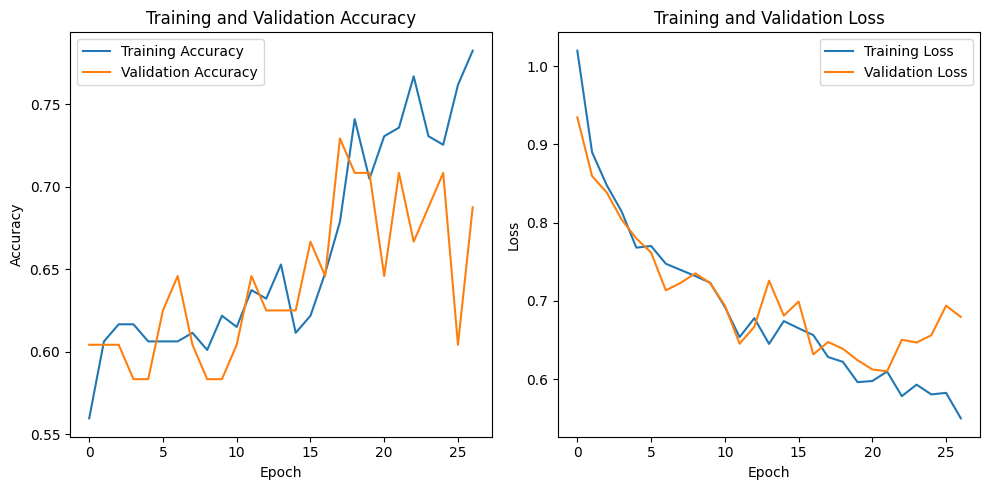

In [5]:
import matplotlib.pyplot as plt

# Plot for accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
model.save('C:/Users/alan/Medical Image Project/CNN model.h5')